In [1]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
!tar -xvf 'drive/MyDrive/OCT2017.tar.gz' -C './'

In [3]:
training_size = 4000
num_class = 4

imageSize=224
train_dir = "./OCT2017/train/"
test_dir =  "./OCT2017/test/"

from tqdm import tqdm
import os
import cv2
import numpy as np
import skimage

def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['CNV']:
                label = 1
            elif folderName in ['DME']:
                label = 2
            elif folderName in ['DRUSEN']:
                label = 3
            else:
                label = 4
            for image_filename in tqdm(os.listdir(folder + folderName)[:int(training_size/num_class)]):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

X_train, y_train = get_data(train_dir)
X_test, y_test= get_data(test_dir)

100%|██████████| 250/250 [00:07<00:00, 35.71it/s]


In [4]:
unique, counts = np.unique(y_train, return_counts=True)

print(X_train.shape)
print(X_test.shape)

for label, count in zip(unique, counts):
  print("The number of {} samples: {}".format(label, count))

(4000, 224, 224, 3)
(1000, 224, 224, 3)
The number of 0 samples: 1000
The number of 1 samples: 1000
The number of 2 samples: 1000
The number of 3 samples: 1000


In [75]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Dropout
from tensorflow.keras.models import Model

In [76]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

In [77]:
base_model_output = base_model.get_layer('block3_pool').output

In [79]:
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)
# Create new model
new_model = Model(inputs=base_model.input, outputs=x)
print(new_model.summary())


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [46]:
x = Conv2D(32, (3, 3), padding='same', activation='relu')(base_model_output)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

In [50]:
for layer in model.layers[1:10]:
    layer.trainable = False

In [51]:
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [82]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [89]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10,validation_data = (X_test, y_test))

Epoch 1/10
125/125 [==============================] - 16s 128ms/step - loss: 0.1761 - accuracy: 0.9383 - val_loss: 0.1642 - val_accuracy: 0.9540
Epoch 2/10
125/125 [==============================] - 15s 118ms/step - loss: 0.1490 - accuracy: 0.9448 - val_loss: 0.1681 - val_accuracy: 0.9490
Epoch 3/10
125/125 [==============================] - 15s 117ms/step - loss: 0.1410 - accuracy: 0.9475 - val_loss: 0.1499 - val_accuracy: 0.9600
Epoch 4/10
125/125 [==============================] - 14s 115ms/step - loss: 0.1195 - accuracy: 0.9572 - val_loss: 0.1755 - val_accuracy: 0.9500
Epoch 5/10
125/125 [==============================] - 14s 114ms/step - loss: 0.1157 - accuracy: 0.9632 - val_loss: 0.1619 - val_accuracy: 0.9600
Epoch 6/10
125/125 [==============================] - 14s 114ms/step - loss: 0.0940 - accuracy: 0.9715 - val_loss: 0.1356 - val_accuracy: 0.9660
Epoch 7/10
125/125 [==============================] - 14s 114ms/step - loss: 0.0876 - accuracy: 0.9668 - val_loss: 0.1549 - val_ac

In [92]:
def plot_learning_curve(history, metrics):
    acc = history.history[metrics]
    val_acc = history.history[f'val_{metrics}']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(5,3))
    plt.plot(epochs, acc, label=f'training {metrics}')
    plt.plot(epochs, val_acc, label=f'validation {metrics}')
    plt.title(f'VGG16TransferLearning_Train Val Accuracy')
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel(metrics)
    plt.legend()

    plt.figure(figsize=(5,3))
    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.title(f'VGG16TransferLearning_Train Val Loss')
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


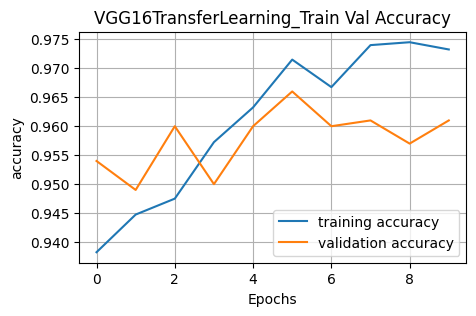

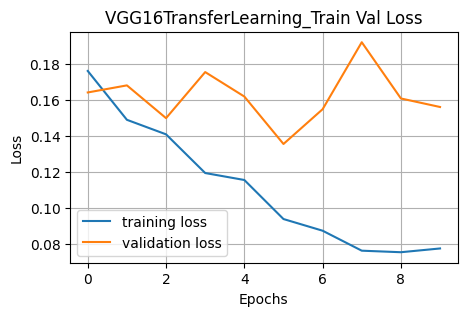

In [93]:
plot_learning_curve(history, metrics='accuracy')

In [98]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


32/32 [==============================] - 3s 89ms/step
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       250
           1       0.93      0.96      0.95       250
           2       0.97      0.95      0.96       250
           3       0.98      0.94      0.96       250

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



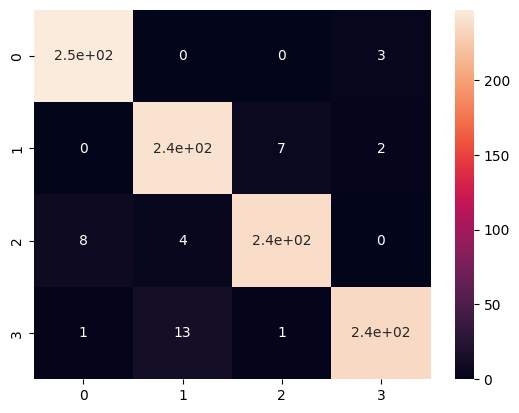

In [99]:
y_pred = model.predict(X_test)
sns.heatmap(confusion_matrix(y_test, np.argmax(y_pred, axis=1)), annot=True)
print(classification_report(y_test, np.argmax(y_pred, axis=1)))
